# Lab 8: Unsupervised Learning – Clustering Techniques and Evaluation

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kneed import KneeLocator

from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
import scipy.cluster.hierarchy as sch

from sklearn.decomposition import PCA

## Exercise 1: Data Understanding and Preprocessing

### 1.	Load the dataset and print .shape, .info(), .describe().

In [2]:
df = pd.read_csv('datasets/Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
df = df.drop(columns=["CustomerID"])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [6]:
df.describe(include='object')

,Gender
count,200
unique,2
top,Female
freq,112


In [7]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### 2. Convert categorical variables using Label Encoding (if required).

In [8]:
le_gender = LabelEncoder()

df['Gender'] = le_gender.fit_transform(df['Gender'])

In [9]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


### 3. Normalize numerical features: Age, Annual Income (k$), Spending Score (1-100).

In [10]:
ss = StandardScaler()

cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
df[cols] = ss.fit_transform(df[cols])
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980


### 4. Visualize pairwise plots and feature distributions.

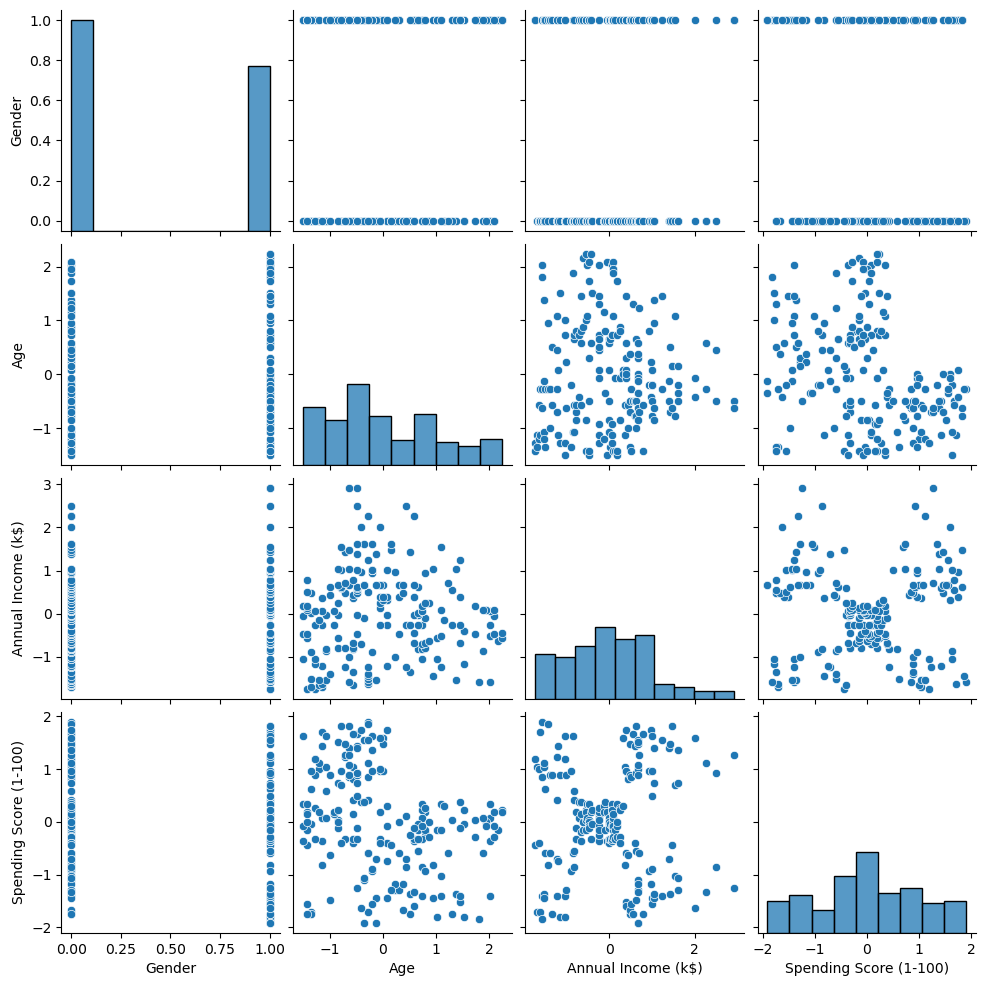

In [11]:
sns.pairplot(df)
plt.show()

### 5. Initializing Results DataFrame

In [12]:
results = pd.DataFrame(columns=["Method", "No. of Clusters", "Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Score"])
results

,Method,No. of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score


## Exercise 2: K-Means Clustering

### 1. Use Elbow Method to determine the optimal value of k.

In [13]:
sse = []
k_values = range(1, 21)
for i in k_values:
    k_means = KMeans(n_clusters=i)
    k_means.fit(df)
    sse.append(k_means.inertia_)

Optimal number of clusters (Elbow): 7


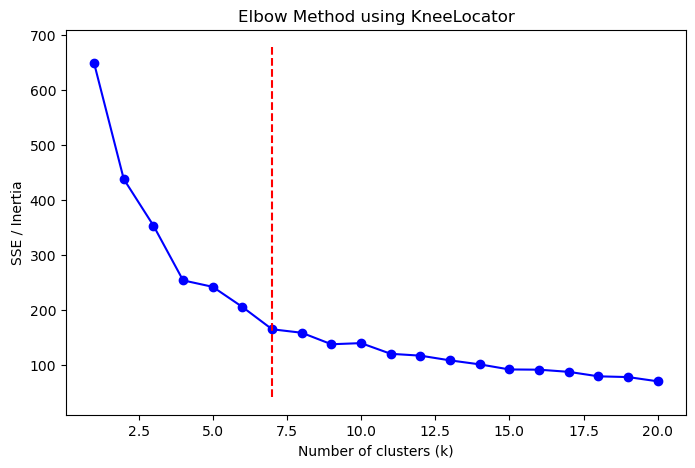

In [14]:
kn = KneeLocator(k_values, sse, curve="convex", direction="decreasing")
print("Optimal number of clusters (Elbow):", kn.elbow)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, 'bo-')
plt.vlines(kn.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE / Inertia")
plt.title("Elbow Method using KneeLocator")
plt.show()

### 2. Apply KMeans clustering with optimal k.

In [15]:
k_means = KMeans(n_clusters=kn.elbow)
k_means.fit(df)

KMeans(n_clusters=np.int64(7))

In [16]:
labels = k_means.predict(df)
labels[:10]

array([3, 4, 3, 4, 3, 4, 6, 4, 6, 4], dtype=int32)

### 3. Visualize clusters using scatter plots and PCA.

In [17]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(x_pca, columns=["pca1", "pca2"])
df_pca.head()

,pca1,pca2
0,-0.600438,-1.737179
1,-1.649886,-1.789124
2,0.315381,-1.692772
3,-1.477989,-1.781317
4,-0.060545,-1.678691


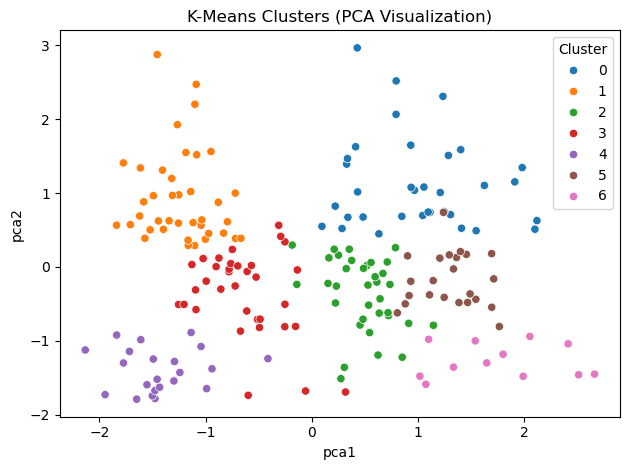

In [18]:
sns.scatterplot(data=df_pca, x="pca1", y="pca2", hue=labels, palette='tab10')
plt.title('K-Means Clusters (PCA Visualization)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 4. Evaluate clusters using:

#### 1. Silhouette Score

In [19]:
ss = silhouette_score(df, labels)
ss

np.float64(0.33473641567598045)

#### 2. Davies-Bouldin Index

In [20]:
dbi = davies_bouldin_score(df, labels)
dbi

np.float64(1.0289829061527709)

#### 3. Calinski-Harabasz Score

In [21]:
chs = calinski_harabasz_score(df, labels)
chs

np.float64(91.4746821969478)

In [22]:
results.loc[len(results)] = ["K-Means", len(k_means.cluster_centers_), ss, dbi, chs]
results

,Method,No. of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,K-Means,7,0.334736,1.028983,91.474682


## Exercise 3: Hierarchical Clustering

### 1. Use dendrogram to determine the number of clusters.

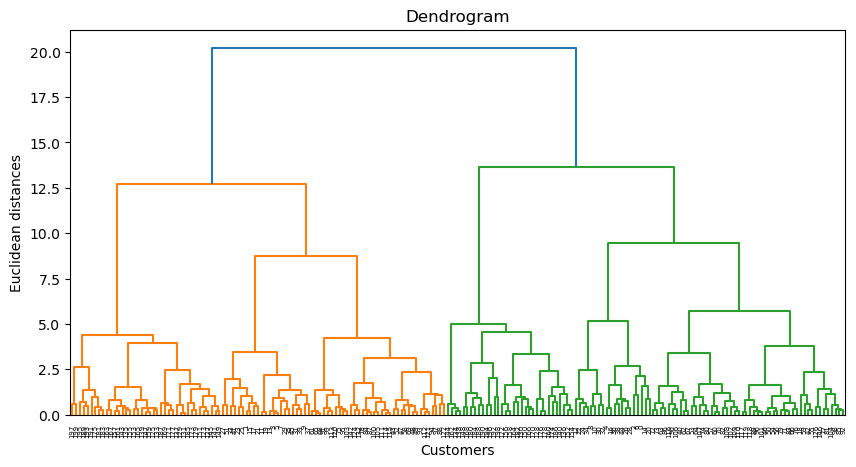

In [23]:
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(df, method="ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

### 2. Apply Agglomerative Clustering.

In [24]:
agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = agg.fit_predict(df)

### 3. Visualize clusters using scatter plots and PCA.

In [25]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(x_pca, columns=["pca1", "pca2"])
df_pca.head()

,pca1,pca2
0,-0.600438,-1.737179
1,-1.649886,-1.789124
2,0.315381,-1.692772
3,-1.477989,-1.781317
4,-0.060545,-1.678691


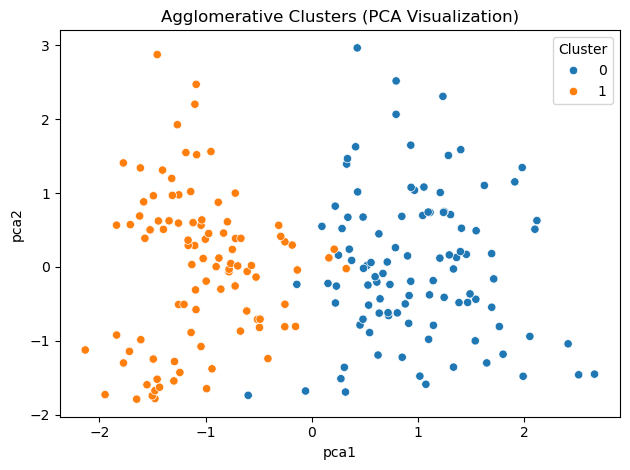

In [26]:
sns.scatterplot(data=df_pca, x="pca1", y="pca2", hue=labels, palette='tab10')
plt.title('Agglomerative Clusters (PCA Visualization)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 4. Evaluate clusters using:

#### 1. Silhouette Score

In [27]:
ss = silhouette_score(df, labels)
ss

np.float64(0.29230406706265116)

#### 2. Davies-Bouldin Index

In [28]:
dbi = davies_bouldin_score(df, labels)
dbi

np.float64(1.3912265045563863)

#### 3. Calinski-Harabasz Score

In [29]:
chs = calinski_harabasz_score(df, labels)
chs

np.float64(90.89431896571952)

In [30]:
results.loc[len(results)] = ["Agglomerative", agg.n_clusters, ss, dbi, chs]
results

,Method,No. of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,K-Means,7,0.334736,1.028983,91.474682
1,Agglomerative,2,0.292304,1.391227,90.894319


## Exercise 4: DBSCAN Clustering

### 1. Apply DBSCAN with suitable eps and min_samples values.

In [31]:
dbscan = DBSCAN(eps=0.6, min_samples=4)
labels = dbscan.fit_predict(df)

In [32]:
noise_points = np.sum(labels == -1)
noise_ratio = noise_points / len(labels)
print(f"Noise points: {noise_points} ({noise_ratio:.2%} of data)")

Noise points: 39 (19.50% of data)


In [33]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

12

### 2. Identify noise points and number of clusters formed.

In [34]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("Estimated number of clusters:", n_clusters)

Estimated number of clusters: 12


### 3. Visualize DBSCAN output.

In [35]:
X_pca = PCA(n_components=2).fit_transform(df)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

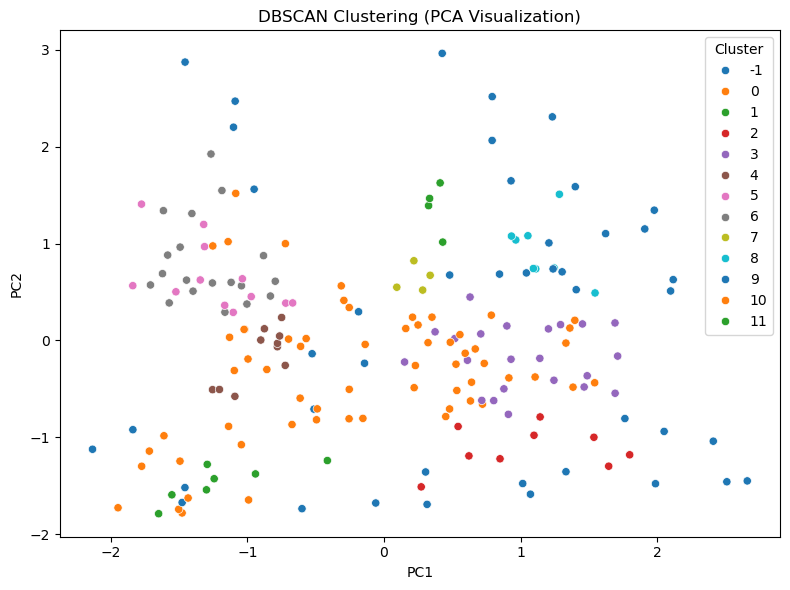

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=labels, palette='tab10')
plt.title('DBSCAN Clustering (PCA Visualization)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### 4. Evaluate clustering (Silhouette Score, DB Index) ignoring noise.

#### 1. Silhouette Score
#### 2. Davies-Bouldin Index

In [37]:
mask = labels != -1
if len(set(labels[mask])) > 1:
    ss = silhouette_score(df[mask], labels[mask])
    display(f"Silhouette Score: {ss}")
    dbi = davies_bouldin_score(df[mask], labels[mask])
    display(f"Davies Bouldin Score: {dbi}")
    results.loc[len(results)] = ["DBSCAB", n_clusters, ss, dbi, None]
    display(results)
else:
    display("Not enough valid clusters for metrics.")

'Silhouette Score: 0.2288549233036872'

'Davies Bouldin Score: 0.9337321240757693'

,Method,No. of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,K-Means,7,0.334736,1.028983,91.474682
1,Agglomerative,2,0.292304,1.391227,90.894319
2,DBSCAB,12,0.228855,0.933732,NaN


## Exercise 5: Comparison Table

In [38]:
results

,Method,No. of Clusters,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Score
0,K-Means,7,0.334736,1.028983,91.474682
1,Agglomerative,2,0.292304,1.391227,90.894319
2,DBSCAB,12,0.228855,0.933732,NaN


## Knowledge Check

1. How does K-Means differ from DBSCAN in identifying clusters?

| Aspect | K-Means | DBSCAN |
|--------|----------|--------|
| Cluster Shape | Assumes clusters are spherical and roughly equal in size. | Can find clusters of any shape or density. |
| Number of Clusters | Must be specified (k) in advance. | Automatically determines the number of clusters. |
| Noise Handling | Every point is forced into some cluster. | Can label outliers as noise (-1). |
| Core Idea | Minimizes distance to centroids (variance-based). | Groups dense regions using eps and min_samples. |

2. What are the advantages of hierarchical clustering?

- No need to pre-specify the number of clusters.
- Produces a dendrogram to visualize the full cluster hierarchy.
- Supports different linkage criteria (Ward, complete, average, single).
- Provides interpretability by showing how clusters are merged at various levels.

3. Why is feature scaling important in clustering?

Clustering algorithms rely on distance calculations (e.g., Euclidean distance).  
If one feature has a much larger numeric range than others, it will dominate the distance metric and distort results.  

4. How do internal metrics differ from external metrics in clustering evaluation?

| Type | Definition | Example | Requires Ground Truth? |
|------|-------------|----------|--------------------------|
| Internal Metrics | Evaluate cluster quality based on data structure (cohesion and separation). | Silhouette Score, Davies–Bouldin Index, Calinski–Harabasz Score | No |
| External Metrics | Compare predicted clusters with known true labels. | Rand Index, Adjusted Mutual Information, Fowlkes–Mallows Index | Yes |


5. What does a negative silhouette score indicate?

A negative silhouette score means that data points are, on average, closer to points in other clusters than to those in their own cluster.

**Interpretation:**
- Poorly assigned clusters.
- Overlapping or incorrect cluster boundaries.
- Possibly wrong distance metric or missing feature scaling.

**Silhouette score range:**
- +1: well-separated clusters  
- 0: overlapping clusters  
- <0: misclassified or incorrect clusters